In [1]:
import numpy as np
import scipy
import scipy.stats
import pandas as pd
import astropy.units as u
import sunpy.map
import sunpy.visualization.colormaps as cm
import cv2
import skimage
import glob
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import random

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn_image as isns
sns.set_style("darkgrid")

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras import layers


import autoenc_model as aem
import data_generator as dg
import utils

2023-04-17 00:06:51.955605: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/eugeniolr/.local/lib/python3.10/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.8.0 and strictly below 2.11.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlo

In [2]:
noise_filter = True

In [3]:
# Read images
data_files = glob.glob("data/composite_data/2016*.npy")
# data_files = glob.glob("data/composite_data_polar/2016*.npy")

if noise_filter:
    noise_imgs = []
    with open("noisy_193A.csv", "r") as f:
        noise_imgs = f.readlines()
    
    noise_imgs = list(map(lambda x: x.strip(), noise_imgs))

    noise_imgs = [x.split("/")[-1].replace(".fits", ".npy") for x in noise_imgs]

    data_files = [f for f in data_files if f.split("/")[-1] not in noise_imgs]

data_matrix = np.empty([len(data_files),256,256,3])

for idx, data_file in enumerate(data_files):
    data_point = np.load(data_file)
    data_matrix[idx] = data_point

data_matrix[:,:,:,0] = np.clip(data_matrix[:,:,:,0], 0, 5000)
data_matrix[:,:,:,1] = np.clip(data_matrix[:,:,:,1], 0, 3000)
data_matrix[:,:,:,2] = np.clip(data_matrix[:,:,:,2], -400, 400)

min_values = np.nanmin(np.nanmin(data_matrix, axis=2, keepdims=True), axis=1, keepdims=True)
max_values = np.nanmax(np.nanmax(data_matrix, axis=2, keepdims=True), axis=1, keepdims=True)

rg = max_values - min_values

rg = np.fmax(rg, 1e-4)

data_matrix_norm = (data_matrix-min_values) / rg

# Normalize HMI magnetogram data differently
hmi_max_values = np.nanmax(np.nanmax(np.abs(data_matrix[:,:,:,2]), axis=2, keepdims=True), axis=1, keepdims=True)

data_matrix_norm[:,:,:,2] = ((data_matrix[:,:,:,2] / hmi_max_values) + 1)/2

data_matrix_norm[np.isnan(data_matrix_norm)] = 0

# data_matrix_norm = (data_matrix_norm*2)-1

input_train, input_test = train_test_split(data_matrix_norm, test_size=0.25)

utils.range_tuple(data_matrix_norm)

/tmp/ipykernel_69829/1241431911.py:26: RuntimeWarning: All-NaN slice encountered
  min_values = np.nanmin(np.nanmin(data_matrix, axis=2, keepdims=True), axis=1, keepdims=True)
/tmp/ipykernel_69829/1241431911.py:27: RuntimeWarning: All-NaN slice encountered
  max_values = np.nanmax(np.nanmax(data_matrix, axis=2, keepdims=True), axis=1, keepdims=True)
/tmp/ipykernel_69829/1241431911.py:36: RuntimeWarning: All-NaN slice encountered
  hmi_max_values = np.nanmax(np.nanmax(np.abs(data_matrix[:,:,:,2]), axis=2, keepdims=True), axis=1, keepdims=True)


(0.0, 1.0)

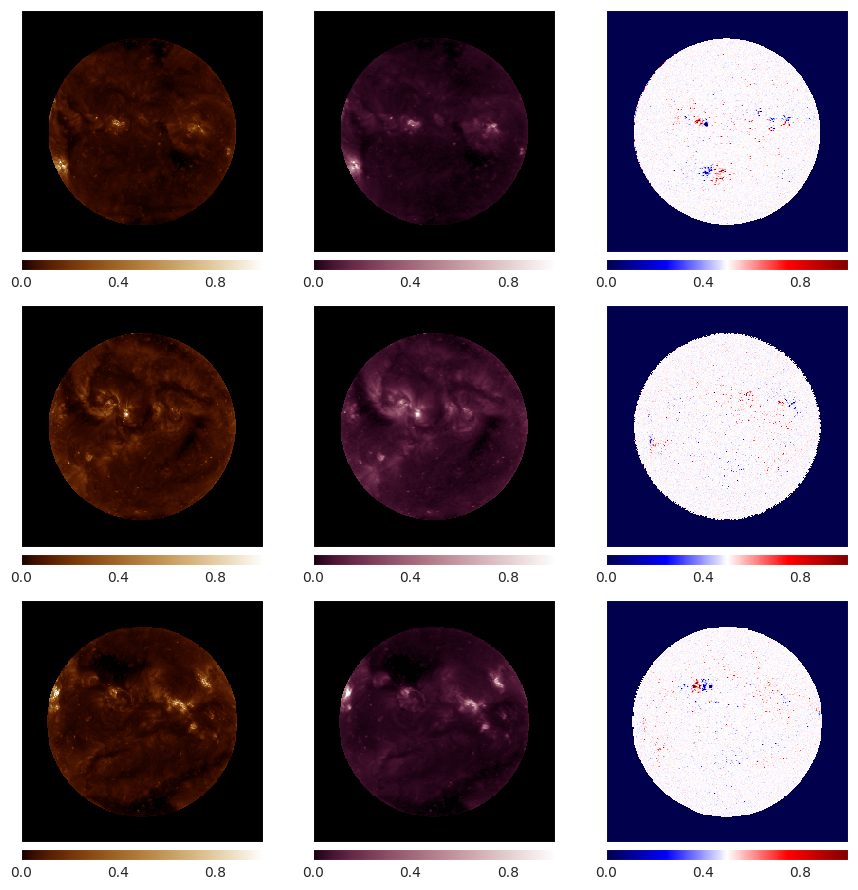

In [4]:
img_amount = 3

image_list = []
for data_image in data_matrix_norm[:img_amount]:
    for channel in data_image.transpose(2,0,1):
        image_list.append(channel)

isns.ImageGrid(image_list, cmap=["sdoaia193", "sdoaia211", "seismic"]*img_amount, orientation="h", vmin=0, vmax=1)

In [5]:
latent_size = 64
# optimizer = keras.optimizers.Adam(learning_rate=0.001)
# optimizer = keras.optimizers.SGD(learning_rate=0.01)
optimizer = keras.optimizers.RMSprop(learning_rate=0.001)

loss_fn = "mse"

autoencoder, encoder, decoder = aem.gen_xception_autoenc_3c(latent_size, optim=optimizer, loss=loss_fn)

2023-04-17 00:07:05.099769: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-17 00:07:05.110291: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-17 00:07:05.110404: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 127, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [6]:
n_epochs = 100
batch_size = 16

history = autoencoder.fit(input_train, input_train, epochs=n_epochs,  validation_split=0.1, batch_size=batch_size)

Epoch 1/100


2023-04-17 00:07:11.111490: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8800
2023-04-17 00:07:12.133274: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


104/104 [==============================] - 20s 124ms/step - loss: 0.0162 - mae: 0.0725 - val_loss: 0.0138 - val_mae: 0.0659
Epoch 2/100
104/104 [==============================] - 9s 87ms/step - loss: 0.0056 - mae: 0.0426 - val_loss: 0.0063 - val_mae: 0.0446
Epoch 3/100
104/104 [==============================] - 9s 88ms/step - loss: 0.0042 - mae: 0.0353 - val_loss: 0.0047 - val_mae: 0.0373
Epoch 4/100
104/104 [==============================] - 9s 91ms/step - loss: 0.0034 - mae: 0.0302 - val_loss: 0.0026 - val_mae: 0.0241
Epoch 5/100
104/104 [==============================] - 9s 89ms/step - loss: 0.0030 - mae: 0.0265 - val_loss: 0.0025 - val_mae: 0.0235
Epoch 6/100
104/104 [==============================] - 10s 93ms/step - loss: 0.0027 - mae: 0.0232 - val_loss: 0.0025 - val_mae: 0.0229
Epoch 7/100
104/104 [==============================] - 9s 89ms/step - loss: 0.0025 - mae: 0.0212 - val_loss: 0.0022 - val_mae: 0.0178
Epoch 8/100
104/104 [==============================] - 9s 88ms/step - l

2023-04-17 00:22:35.045508: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 260.20MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-17 00:22:35.045538: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 260.20MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-17 00:22:35.045547: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 260.20MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-17 00:22:35.045555: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocato

20/20 [==============================] - 3s 73ms/step - loss: 0.0013 - mae: 0.0110


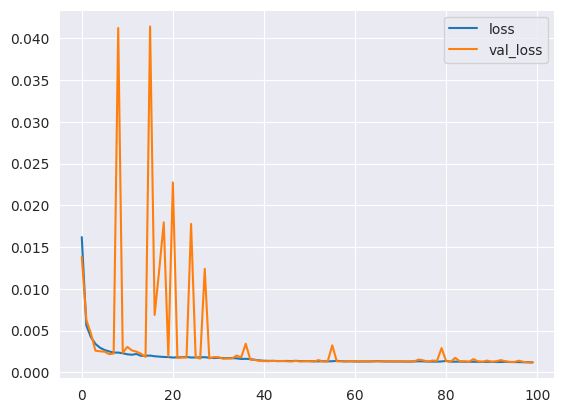

In [7]:
autoencoder.evaluate(input_test, input_test)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

(1, 256, 256, 3)


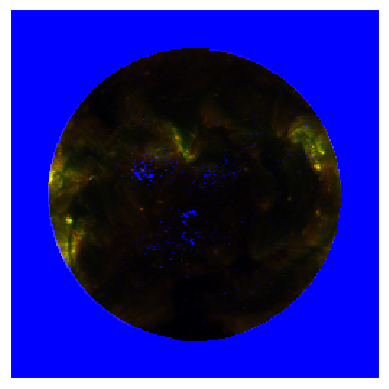

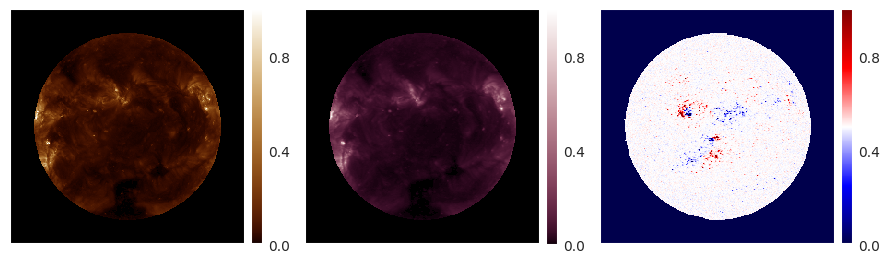

In [17]:
test_img = np.array(random.choices(input_test, k=1))
print(test_img.shape)

test_img_display = test_img[0].copy()
test_img_display[:,:,2] = np.abs((0.5 - test_img_display[:,:,2])*2)
isns.imgplot(test_img_display)
isns.rgbplot(test_img[0], cmap=["sdoaia193", "sdoaia211", "seismic"], vmin=0, vmax=1)

<AxesSubplot: >

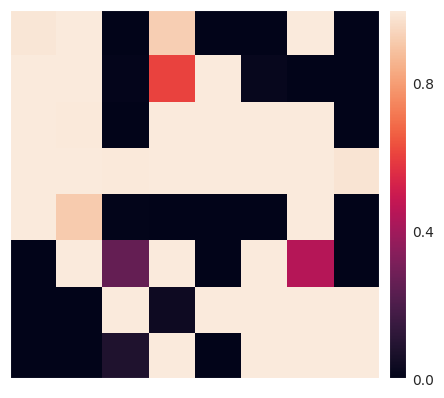

In [18]:
code = encoder(test_img)
# isns.imgplot(np.reshape(code[0], (6, 8)))
isns.imgplot(np.reshape(code[0], (8, 8)))

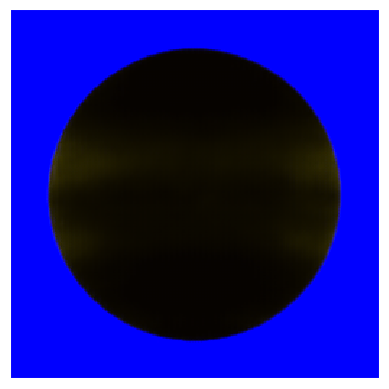

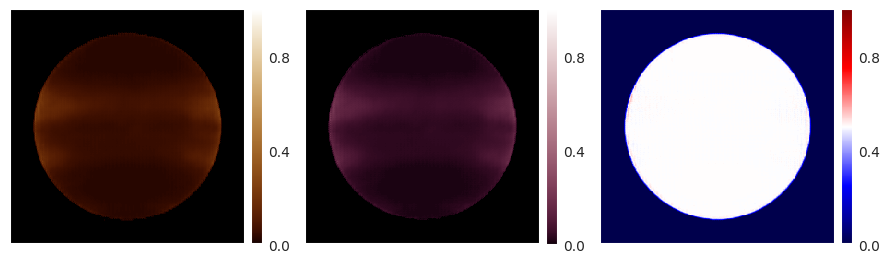

In [19]:
decoded = decoder(code)
# isns.imgplot(decoded[0])
decoded_display = np.copy(decoded[0])
decoded_display[:,:,2] = np.abs((0.5 - decoded_display[:,:,2])*2)
isns.imgplot(decoded_display)
isns.rgbplot(decoded[0], cmap=["sdoaia193", "sdoaia211", "seismic"], vmin=0, vmax=1)